In [3]:
import os
import glob
import tqdm
import torch
import numpy as np
import omegaconf
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from mllib.src.evaluate import evaluate
from mllib.src.utils import prepare_device, load_yaml

/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [4]:
# config = "./result/demucs/20230201-104202/config.yaml"
# config = "./result/wav-unet/20230201-104328/config.yaml"
# config = "./result/dcunet/20230201-104116/config.yaml"

# config = "/home/daniel0413/workplace/project/SpeechEnhancement/SpeechEnhancementHL/result/dcunet/20230128-234556/config.yaml"

# config = "./result/mel-rnn/20230202-145405/config.yaml"
# config = './result/mel-rnn/20230203-121042/config.yaml'

# config = "./result/dnn/20230202-142249/config.yaml"
# config = "./result/dnn/20230202-163959/config.yaml"
# config = "./result/dnn/20230202-170504/config.yaml"
# config = "./result/dnn/20230202-171624/config.yaml"
# config = "./result/dnn/20230202-185453/config.yaml"
# config = "./result/dnn/20230203-115011/config.yaml"

# config= "./result/unet/20230203-183804/config.yaml"

config= "./result/conv-tasnet/20230203-183838/config.yaml"

In [5]:
solver = main(path_config=config, return_solver=True)

------------------------------
	Search training datasets...
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300
------------------------------
	Loading data loader...
	The number of CPU:  20
------------------------------
	Loading Model...
ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(2, 128, kernel_size=(40,), stride=(20,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
          (0): TemporalBlock(
            (net): Sequential(
              (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
              (1): PReLU(num_parameters=1)
              (2): GlobalLayerNorm()
              (3): DepthwiseSeparableConv(
            

In [6]:
test_data = solver.test_dataloader
model = solver.model

In [7]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [8]:
args.default.dset.name = "Clarity"
# args.default.dset.name = "VoiceBankDEMAND"

if args.default.dset.name == "VoiceBankDEMAND":
    log_voicebank = "./mllib/data/VoiceBankDEMAND/DS_10283_2791/logfiles"
    text_files = glob.glob(
        os.path.join(log_voicebank, "*trainset*")
    )
    print(text_files)
    metadata = []
    for text_file in text_files:
        with open(text_file, "r") as tmp:
            text = tmp.read().split("\n")
            for i, t in enumerate(text):
                text[i] = t.split(" ")
        
            metadata.append(text)
    print(metadata[0][0])

elif args.default.dset.name == "Clarity":
    log_clarity = "/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/custom_metadata/scenes.train.snr.json"
    metadata = omegaconf.OmegaConf.load(log_clarity)
    print(list(metadata.values())[0], list(metadata.keys())[0])

1.1382 S00001


In [10]:
from mllib.src.distrib import get_train_wav_dataset

SNR = '0' # '0', '5', '10', '15' # SNR = P_{Signal} / P_{Noise}

test_dataset = None

if args.default.dset.name == "VoiceBankDEMAND":
    args.dset.wav = './mllib/data/VoiceBankDEMAND/DS_10283_2791'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset, name="VoiceBankDEMAND")

elif args.default.dset.name == "Clarity":
    args.dset.wav = '/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data'
    args.default.dset.config = './recipes/icassp_2023/MLbaseline/config_train.yaml'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset, name="Clarity")

dataset = test_dataset

flag_find = False
data_test = None

if args.default.dset.name == "VoiceBankDEMAND":
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, clean, origial_length, name = data
        for imetadata in range(len(metadata)):
            for ifile in range(len(metadata[imetadata])):
                if metadata[imetadata][ifile][0] == name:
                    if metadata[imetadata][ifile][-1] == SNR:
                        flag_find = True
                    else:
                        break
        if flag_find:
            data_test = data
            break

elif args.default.dset.name == "Clarity":
    # data_test = dataset[0]
    # mixture, clean, origial_length, name = data_test
    # scene_name = name.split("_")[0]
    # SNR = metadata[scene_name]
    # print("Clarity dataset SNR: ", SNR)

    SNR = 5
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, clean, interferer, origial_length, name = data
        scene_name = name.split("_")[0]
        if metadata[scene_name] > SNR:
            data_test = data
            SNR = metadata[scene_name]
            break
    
    print("Clarity dataset SNR: ", SNR)

# data_test

	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300


  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

Clarity dataset SNR:  5.498


In [12]:
mixture, clean, interferer, origial_length, name = data_test

In [13]:
mixture.shape

torch.Size([2, 97613])

In [14]:
nchannel, nsample = mixture.shape
if args.model.name in ("demucs", "conv-tasnet") and nchannel == 1:
    try:
        mixture = torch.cat(tensors=[mixture[None], mixture[None]], dim=1)
        clean = torch.cat(tensors=[clean[None], clean[None]], dim=1)
    except AttributeError:
        # For torch 1.7.1, AttributeError: module 'torch' has no attribute 'concat'
        mixture = torch.cat(tensors=[mixture[None], mixture[None]], dim=1)
        clean = torch.cat(tensors=[clean[None], clean[None]], dim=1)

if args.model.name not in ("demucs", "conv-tasnet"):
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


In [15]:
mixture.shape, args.model.name

(torch.Size([2, 97613]), 'conv-tasnet')

In [16]:
enhanced = evaluate(mixture=mixture[None], model=model, device=device, config=args)

In [17]:
assert enhanced.shape[-1] == mixture.shape[-1] == clean.shape[-1]

In [34]:
enhanced = enhanced.detach().cpu()
if args.default.dset.name == "Clarity" and args.model.name in ("demucs", "conv-tasnet"):
    enhanced_0 = enhanced[:, 0, ...]
    enhanced_1 = enhanced[:, 1, ...]
else:
    enhanced_0 = enhanced
    enhanced_1 = enhanced

In [35]:
enhanced_0.shape, enhanced_1.shape, mixture.shape, clean.shape

(torch.Size([1, 2, 97613]),
 torch.Size([1, 2, 97613]),
 torch.Size([2, 97613]),
 torch.Size([2, 97613]))

In [39]:
enhanced_0_np = enhanced_0[:]
enhanced_1_np = enhanced_1[:]
mixture_np = mixture[:]
clean_np = clean[:]

In [40]:
enhanced_0_np = enhanced_0.flatten().numpy()
enhanced_1_np = enhanced_1.flatten().numpy()
mixture_np = mixture.flatten().numpy()
clean_np = clean.flatten().numpy()

In [41]:
enhanced_0_np.shape, enhanced_1_np.shape, mixture_np.shape, clean_np.shape

((195226,), (195226,), (195226,), (195226,))

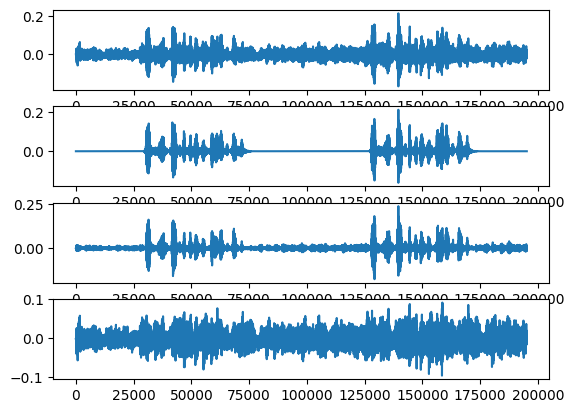

In [42]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4)

ax0.plot(mixture_np)
ax1.plot(clean_np)
ax2.plot(enhanced_0_np)
ax3.plot(enhanced_1_np)


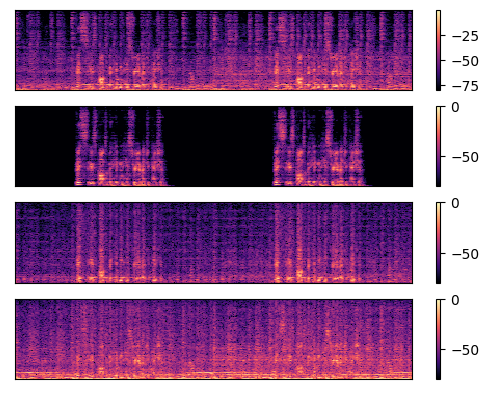

In [43]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(mixture_np, fig, ax0)
show_stft(clean_np, fig, ax1)
show_stft(enhanced_0_np, fig, ax2)
show_stft(enhanced_1_np, fig, ax3)

In [44]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [45]:
ipd.Audio(clean_np, rate=args.dset.sample_rate)

In [47]:
ipd.Audio(enhanced_0_np, rate=args.dset.sample_rate)

In [48]:
ipd.Audio(enhanced_1_np, rate=args.dset.sample_rate)

In [49]:
from mllib.src.metric import SI_SDR, STOI, WB_PESQ

In [50]:
metrics = [SI_SDR, STOI, WB_PESQ]

clean_score = np.expand_dims(np.expand_dims(clean_np, 0), 0)
mixture_score = np.expand_dims(np.expand_dims(mixture_np, 0), 0)
enhanced_score = np.expand_dims(np.expand_dims(enhanced_0_np, 0), 0)

print(clean_score.shape, mixture_score.shape, enhanced_score.shape)

for metric in metrics:
    print("Mixture", metric, metric(clean_score, mixture_score, sr=args.dset.sample_rate))
    print("Enhanced", metric, metric(clean_score, enhanced_score, sr=args.dset.sample_rate))

(1, 1, 195226) (1, 1, 195226) (1, 1, 195226)
Mixture <function SI_SDR at 0x7f4751951430> -0.6158554926514626
Enhanced <function SI_SDR at 0x7f4751951430> 4.094815254211426
Mixture <function STOI at 0x7f4731f443a0> 0.8268794499749873
Enhanced <function STOI at 0x7f4731f443a0> 0.8198305743787391
Mixture <function WB_PESQ at 0x7f4731f44430> 0
Enhanced <function WB_PESQ at 0x7f4731f44430> 0
